In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import MNISTNet
from sklearn.metrics import confusion_matrix
import itertools
from torch.utils.data import random_split

In [13]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
def train(model, device, train_loader, val_loader, optimizer, epoch, history):
    model.train()
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

        if batch_idx % 100 == 0:
            train_accuracy = 100. * total_correct / total_samples

            # Run validation and get accuracy
            val_loss, val_accuracy = validate(model, device, val_loader)

            # Store data for visualization
            history["train_loss"].append(loss.item())
            history["train_acc"].append(train_accuracy)
            history["val_acc"].append(val_accuracy)

            # Print output in a single line
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)] '
                  f'Loss: {loss.item():.6f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')

    print(f'Final Training Accuracy: {train_accuracy:.2f}%')

In [15]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, accuracy

In [16]:
def test(model, device, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({test_accuracy:.2f}%)\n')

In [17]:
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f'Using device: {device}')

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    num_epochs = 10
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, val_loader, optimizer, epoch, history)  # Now history is defined

    print("\nEvaluating on Test Set...")
    test(model, device, test_loader)

    torch.save(model.state_dict(), "mnist_cnn.pt")
    print("Model saved as mnist_cnn.pt")

    # Save history for later visualization
    torch.save(history, "training_history.pt")
    print("Training history saved as training_history.pt")

if __name__ == "__main__":
    main()

Using device: cpu
Epoch 1 [0/48000 (0%)] Loss: 2.316676 | Train Acc: 4.69% | Val Acc: 25.26%
Epoch 1 [6400/48000 (13%)] Loss: 0.063464 | Train Acc: 86.80% | Val Acc: 95.42%
Epoch 1 [12800/48000 (27%)] Loss: 0.138080 | Train Acc: 91.45% | Val Acc: 96.87%
Epoch 1 [19200/48000 (40%)] Loss: 0.065509 | Train Acc: 93.30% | Val Acc: 97.33%
Epoch 1 [25600/48000 (53%)] Loss: 0.111880 | Train Acc: 94.40% | Val Acc: 97.52%
Epoch 1 [32000/48000 (67%)] Loss: 0.073961 | Train Acc: 95.09% | Val Acc: 98.17%
Epoch 1 [38400/48000 (80%)] Loss: 0.014536 | Train Acc: 95.55% | Val Acc: 98.31%
Epoch 1 [44800/48000 (93%)] Loss: 0.070663 | Train Acc: 95.89% | Val Acc: 98.17%
Final Training Accuracy: 95.89%
Epoch 2 [0/48000 (0%)] Loss: 0.147982 | Train Acc: 93.75% | Val Acc: 97.83%
Epoch 2 [6400/48000 (13%)] Loss: 0.023109 | Train Acc: 98.84% | Val Acc: 98.29%
Epoch 2 [12800/48000 (27%)] Loss: 0.116517 | Train Acc: 98.78% | Val Acc: 98.21%
Epoch 2 [19200/48000 (40%)] Loss: 0.005673 | Train Acc: 98.80% | Val Acc

<ipython-input-18-73109c0c63d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load("training_history.pt")


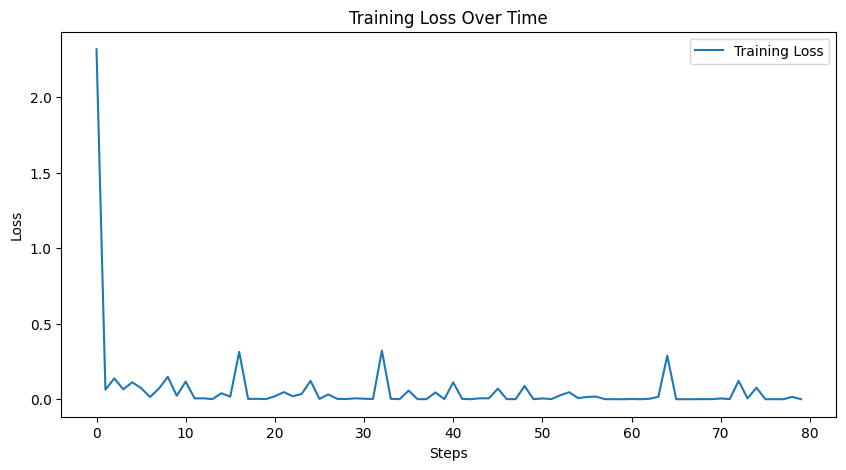

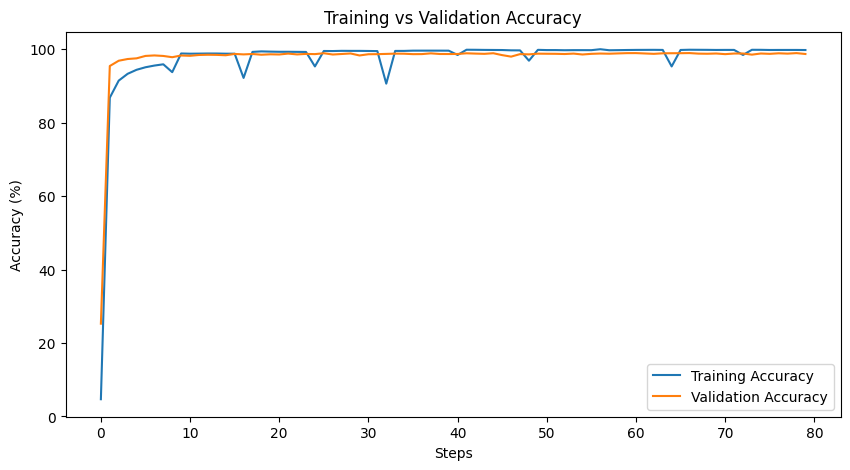

In [18]:
import torch
import matplotlib.pyplot as plt

# Load stored training history
history = torch.load("training_history.pt")

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


<ipython-input-23-2fbb06e93321>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn.pt"))


Accuracy: 98.66%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


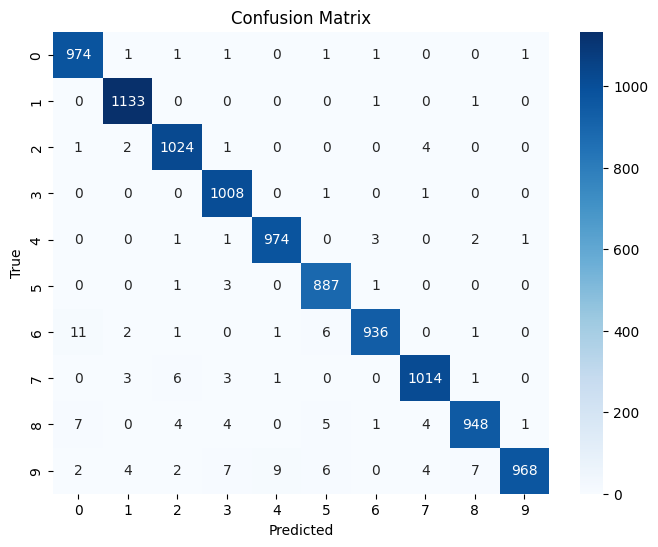

In [23]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform and dataset (using the same transformations used for training)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTNet().to(device)
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

# Function to compute metrics and confusion matrix
def compute_metrics(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Calculate Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print out the metrics
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to compute and display metrics
compute_metrics(model, test_loader)


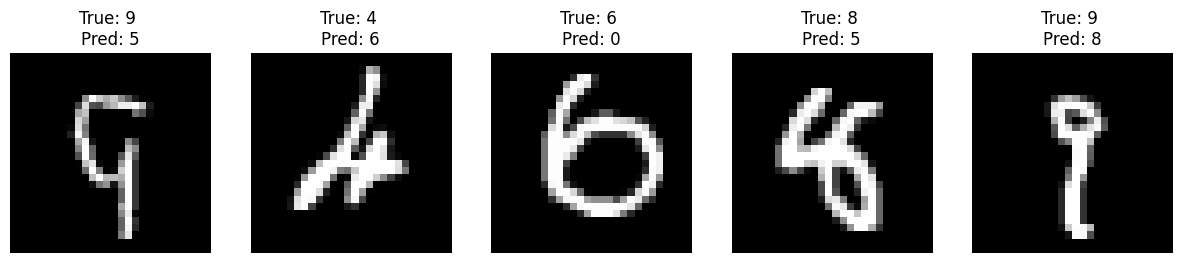

In [24]:
def show_misclassified_images(model, test_loader, num_images=5):
    misclassified_images = []
    misclassified_labels = []
    predicted_labels = []

    # Iterate through the test set
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # Identify misclassified images
            incorrect = pred.squeeze() != target
            misclassified_images.extend(data[incorrect].cpu())
            misclassified_labels.extend(target[incorrect].cpu())
            predicted_labels.extend(pred[incorrect].cpu())

            # Stop when we've collected enough misclassified images
            if len(misclassified_images) >= num_images:
                break

    # Display the misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(misclassified_images[i].squeeze(), cmap='gray')
        ax.set_title(f"True: {misclassified_labels[i].item()} \nPred: {predicted_labels[i].item()}")
        ax.axis('off')
    plt.show()

# Call the function to display misclassified images
show_misclassified_images(model, test_loader, num_images=5)